In [1]:
from jupyter_imports import *
from copy import deepcopy

In [2]:
# run only once
from utils.MyLogger import ExecutionLogger # use 'prod' for remote after cache_tmp
start = datetime(2022,7,10,0)#,tzinfo=timezone.utc)
dirname = os.path.join(os.sep, 'tmp','','tradeexecutor')#,'prod')
ExecutionLogger.batch_summarize_exec_logs(dirname=dirname,start=start,add_history_context=False,rebuild=True)

'moved 0 logs to unreadable'

In [18]:
files = ['all_by_clientOrderId','all_by_coin','all_by_symbol','all_order_manager','all_parameters']
original = {file:pd.read_csv(os.path.join(os.sep, dirname,f'{file}.csv'),index_col=0) for file in files}

In [7]:
cmap = cm.get_cmap('Spectral')
#fig, ax = plt.subplots(1)

## parameters for reference

In [19]:
all_parameters = original['all_parameters']
all_parameters['hash'] = all_parameters['timestamp'].apply(lambda x: pd.util.hash_pandas_object(all_parameters.groupby('timestamp').get_group(x).astype(str)).sum())
all_parameters['param_index'] = all_parameters['hash'].apply(lambda h: list(all_parameters['hash'].unique()).index(h))
all_parameters.drop(columns=['hash'],inplace=True)
param_map = all_parameters.set_index('timestamp')['param_index'].to_dict()
param_map

{1659458523170.565: 0}

In [20]:
indexed = deepcopy(original)
for df in indexed.values():
    df['param_index'] = df['timestamp'].apply(lambda x:param_map[x])
#colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(all_parameters['param_index'].unique())))

KeyError: 'timestamp'

### slippage, fees in bps. filled in USD

In [47]:
print(indexed['all_by_symbol'].describe())
indexed['all_by_symbol']

       time_to_execute  slippage_bps  fee  filledUSD  absFilled   total_bps  \
count         2.000000      3.000000  3.0   3.000000   3.000000    3.000000   
mean     163163.650024      1.369517  0.0   4.480500   8.959200    1.369517   
std      230042.821420    227.397169  0.0  10.263464   3.879448  227.397169   
min         498.811035   -226.042880  0.0  -6.718050   6.718050 -226.042880   
25%       81831.230530   -112.321453  0.0   0.001350   6.719400 -112.321453   
50%      163163.650024      1.399974  0.0   6.720750   6.720750    1.399974   
75%      244496.069519    115.075715  0.0  10.079775  10.079775  115.075715   
max      325828.489014    228.751455  0.0  13.438800  13.438800  228.751455   

       fee_USD  slippage_USD  total_USD  
count      3.0      3.000000   3.000000  
mean       0.0      0.001254   0.001254  
std        0.0      0.152798   0.152798  
min        0.0     -0.151857  -0.151857  
25%        0.0     -0.074988  -0.074988  
50%        0.0      0.001881   0.001

,index,time_to_execute,slippage_bps,fee,filledUSD,coin,absFilled,total_bps,fee_USD,slippage_USD,total_USD
0,LINK/USD,325828.489014,-226.042880,0.0,-6.71805,LINK,6.71805,-226.042880,0.0,-0.151857,-0.151857
1,LINK/USD:USD,498.811035,228.751455,0.0,6.72075,LINK,6.72075,228.751455,0.0,0.153738,0.153738
2,average,NaN,1.399974,0.0,13.43880,NaN,13.43880,1.399974,0.0,0.001881,0.001881


### slippage distribution

In [46]:
print(indexed['all_by_coin'].describe())
indexed['all_by_coin']

       perleg_fee_bps  perleg_filled_USD  premium_vs_inception_bps
count             2.0             2.0000                  2.000000
mean              0.0             6.7194                  2.799949
std               0.0             0.0000                  0.000000
min               0.0             6.7194                  2.799949
25%               0.0             6.7194                  2.799949
50%               0.0             6.7194                  2.799949
75%               0.0             6.7194                  2.799949
max               0.0             6.7194                  2.799949


,index,perleg_fee_bps,perleg_filled_USD,premium_vs_inception_bps
0,LINK,0.0,6.7194,2.799949
1,average,0.0,6.7194,2.799949


# tick to ack

,index,symbol,coin,order_ref,pending_local,pending_to_ack_local,mid_at_pending,amount,filled,price,fee,last_fill_local
0,new_LINK/USD:USD_1659458476158,LINK/USD:USD,LINK,7.3005,1.659458e+12,414.435059,7.46725,0.9,0.9,7.4675,0.0,1.659458e+12
1,new_LINK/USD_1659458150302,LINK/USD,LINK,7.2995,1.659458e+12,372.713135,7.43750,-0.9,-0.9,7.4645,0.0,1.659458e+12


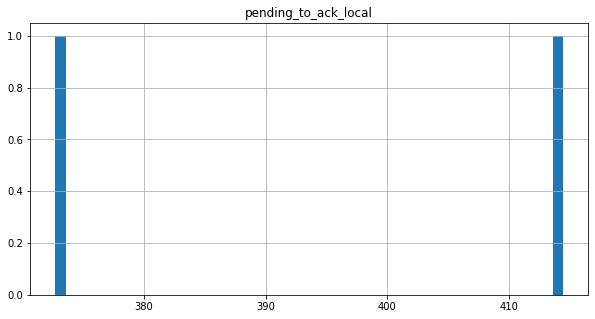

In [49]:
by_clientOrderId = indexed['all_by_clientOrderId']
tick_to_order_local = by_clientOrderId[['pending_to_ack_local']]
tick_to_order_local.hist(bins=50,figsize=(10,5))
tick_to_order_local.describe()
by_clientOrderId

# remote vs local (~ round trip)

,timestamp,remote_timestamp
0,-372868.330078,NaN
1,-372512.594971,-372642.564941
2,-372495.616943,-372642.564941
3,-47039.840820,-47175.564941
4,-47012.331055,NaN
5,-46623.947021,-46757.564941
6,-46597.895996,-46757.564941
7,-46513.520020,-46695.564941


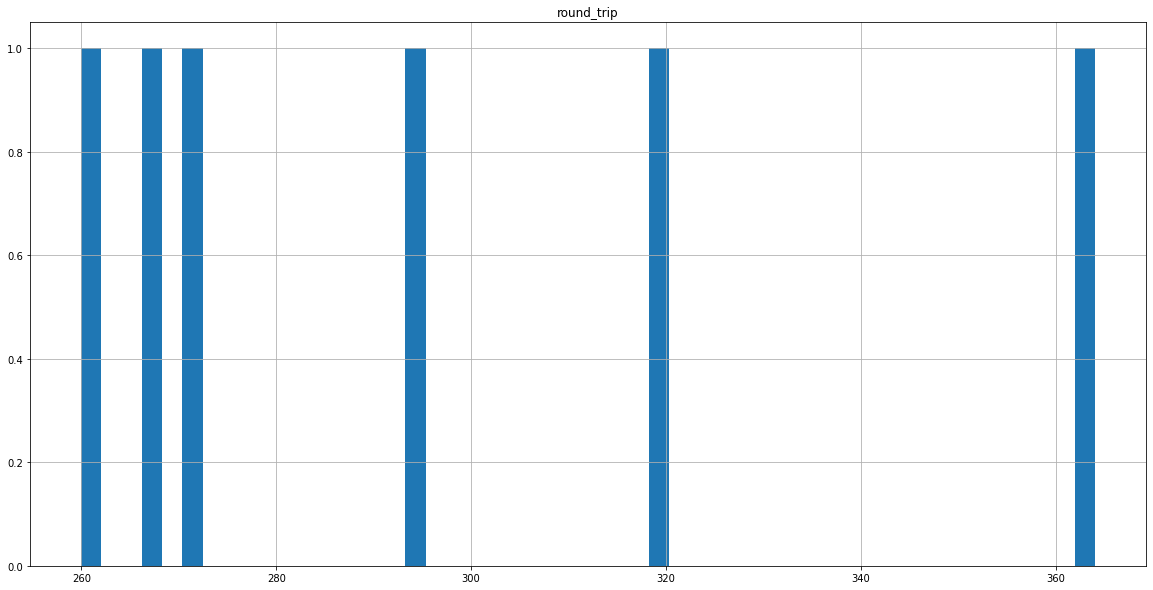

In [58]:
round_trip = pd.DataFrame(columns=['round_trip'], data = 2*(indexed['all_order_manager']['timestamp']-indexed['all_order_manager']['remote_timestamp']))
round_trip.hist(bins=50,figsize=(20,10))
round_trip.describe()
indexed['all_order_manager'][['timestamp','remote_timestamp']] - indexed['all_parameters']['timestamp'].squeeze()